In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import src.data_utils as data_utils
import src.tree_build as dt_tree
import src.heurestics as dt_heur
import src.tree_utils as tree_utils
import src.dt_testing_utils as dt_testing
import src.tree_pruning as tree_pruning

from pprint import pprint
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Car dataset

## Dataset preparation

In [3]:
car_dataset_path = 'data/car.data'
car_dataset_labels = ['buying','maint','doors','persons','lug_boot','safety','CLASS']
car_dataset = data_utils.preapare_dataset(car_dataset_path, car_dataset_labels)
car_dataset.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,vhigh,low,2,4,big,high,acc
1,low,high,5more,more,small,med,acc
2,vhigh,vhigh,4,2,small,med,unacc
3,low,vhigh,2,4,big,high,acc
4,high,vhigh,2,more,big,high,unacc


unacc    570
acc      172
good      32
vgood     31
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

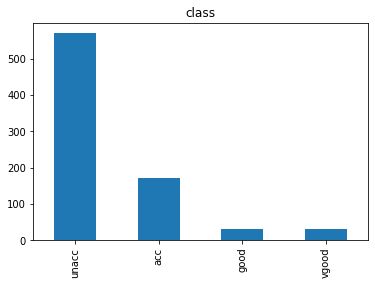

In [4]:
car_set_for_training, car_testing = data_utils.data_split(car_dataset, 70)
car_training, car_validation = data_utils.split_training_data_for_pruning(car_set_for_training)
print(car_training['CLASS'].value_counts())
car_training['CLASS'].value_counts().plot(kind='bar', title='class')

In [5]:
car_training

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,vhigh,low,2,4,big,high,acc
1,low,high,5more,more,small,med,acc
2,vhigh,vhigh,4,2,small,med,unacc
3,low,vhigh,2,4,big,high,acc
4,high,vhigh,2,more,big,high,unacc
...,...,...,...,...,...,...,...
800,high,low,3,more,small,med,unacc
801,med,low,5more,more,small,med,acc
802,high,high,5more,4,small,low,unacc
803,high,high,2,more,small,low,unacc


<AxesSubplot:title={'center':'class'}>

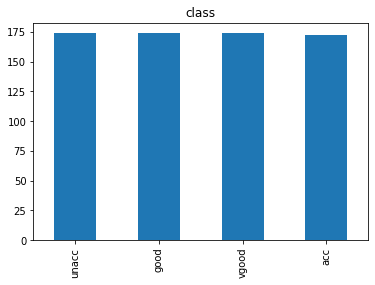

In [6]:
#Target for all 174
resampling_car = car_training.copy()
unacc_part = resampling_car[resampling_car['CLASS'] == 'unacc']
acc_part = resampling_car[resampling_car['CLASS'] == 'acc'] 
vgood_part = resampling_car[resampling_car['CLASS'] == 'vgood'] 
good_part = resampling_car[resampling_car['CLASS'] == 'good'] 


unacc_downsample = resample(unacc_part, 
                                 replace=False,     
                                 n_samples=174)

vgood_part_upsampled = resample(vgood_part, 
                                 replace=True,     
                                 n_samples=174)
good_part_upsampled = resample(good_part, 
                                 replace=True,     
                                 n_samples=174)

# Combine majority class with upsamplet minority class
balanced_car_training= pd.concat([unacc_downsample, acc_part, vgood_part_upsampled, good_part_upsampled])
balanced_car_training = balanced_car_training.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_car_training = balanced_car_training.sample(frac=1).reset_index(drop=True)

car_training = balanced_car_training.copy()
car_training['CLASS'].value_counts().plot(kind='bar', title='class')

In [7]:
car_training.head()

,buying,maint,doors,persons,lug_boot,safety,CLASS
0,med,med,4,more,med,high,vgood
1,med,low,5more,more,big,med,good
2,low,high,5more,4,big,high,vgood
3,low,med,4,more,med,med,good
4,med,low,5more,more,big,high,vgood


## Model Training

In [8]:
"""
TODO:
Handling of all heuristics
"""
car_tree= dt_tree.build_tree_generic(dt_heur.j_measure,car_training)
pprint(car_tree)
tree_accuracy_car_training = tree_utils.tree_accuracy(car_training, car_tree)
tree_accuracy_car_testing = tree_utils.tree_accuracy(car_testing, car_tree)

{<safety(0.52)>: high[361] low[80] med[253] : {'high': {<lug_boot(0.44)>: big[140] med[119] small[102] : {'big': {<persons(0.38)>: 2[11] 4[66] more[63] : {'2': 'unacc',
                                                                                                                                                           '4': {<maint(0.29)>: high[13] low[25] med[22] vhigh[6] : {'high': {<buying(0.96)>: high[2] low[8] med[3] : {'high': 'acc',
                                                                                                                                                                                                                                                                       'low': 'vgood',
                                                                                                                                                                                                                                                                       'med': 'acc

In [9]:
print("Tree accuracy for testing data {0}% and for training {1}%\n".format(tree_accuracy_car_testing, tree_accuracy_car_training ))
print("Tree number of levels:", tree_utils.number_of_levels(car_tree))
print("Tree number of leafs:", tree_utils.number_of_leafs(car_tree))

Tree accuracy for testing data 84.00770712909441% and for training 96.82997118155619%

Tree number of levels: 10
Tree number of leafs: 115


In [10]:
pruned_tree_car = tree_pruning.reduced_error_pruning(car_tree, car_validation)
pprint(pruned_tree_car)

{<safety(0.52)>: high[361] low[80] med[253] : {'high': {<lug_boot(0.44)>: big[140] med[119] small[102] : {'big': {<persons(0.38)>: 2[11] 4[66] more[63] : {'2': 'unacc',
                                                                                                                                                           '4': {<maint(0.29)>: high[13] low[25] med[22] vhigh[6] : {'high': {<buying(0.96)>: high[2] low[8] med[3] : {'high': 'acc',
                                                                                                                                                                                                                                                                       'low': 'vgood',
                                                                                                                                                                                                                                                                       'med': 'acc

In [11]:
tree_accuracy_car_training2 = tree_utils.tree_accuracy(car_training, pruned_tree_car)
tree_accuracy_car_testing2 = tree_utils.tree_accuracy(car_testing, pruned_tree_car)

print("Tree accuracy after pruning for testing data {0}% and for training {1}%".format(tree_accuracy_car_testing2, tree_accuracy_car_training2 ))
print("Tree number of levels:", tree_utils.number_of_levels(pruned_tree_car))
print("Tree number of leafs:", tree_utils.number_of_leafs(pruned_tree_car))

Tree accuracy after pruning for testing data 84.00770712909441% and for training 96.82997118155619%
Tree number of levels: 10
Tree number of leafs: 115


# CMC Dataset

## Dataset preparation

In [12]:
cmc_dataset_path = 'data/cmc.data'
cmc_dataset_labels = ['age','education','husbandEducation','noChildren','religion','isWorking','husbandOccupation','livingStandard', 'mediaExposure', 'CLASS']
cmc_dataset = data_utils.preapare_dataset(cmc_dataset_path, cmc_dataset_labels)
# cmc_dataset['CLASS'] = cmc_dataset['CLASS'].apply(str)
cmc_dataset.head()

,age,education,husbandEducation,noChildren,religion,isWorking,husbandOccupation,livingStandard,mediaExposure,CLASS
0,34,4,4,3,0,1,1,2,0,1
1,20,4,3,1,1,1,3,4,0,3
2,23,4,4,2,1,0,3,3,0,1
3,35,1,3,7,1,0,2,3,1,2
4,23,4,4,1,1,1,3,3,0,2


1    298
3    224
2    165
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

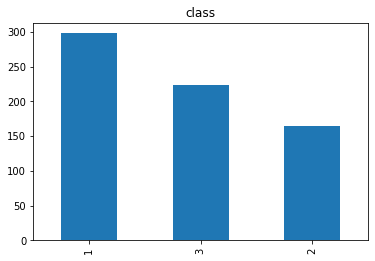

In [13]:
cmc_set_for_training, cmc_testing = data_utils.data_split(cmc_dataset, 70)
cmc_training, cmc_validation = data_utils.split_training_data_for_pruning(cmc_set_for_training)
print(cmc_training['CLASS'].value_counts())
#This data seems to be balanced so dont need aditional balancing
cmc_training['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [14]:
cmc_tree = dt_tree.build_tree_generic(dt_heur.distance_measure,cmc_training)
pprint(cmc_tree)
tree_accuracy_cmc_training = tree_utils.tree_accuracy(cmc_training, cmc_tree)
tree_accuracy_cmc_testing = tree_utils.tree_accuracy(cmc_testing, cmc_tree)

{<isWorking(1.00)>: 0[163] 1[524] : {0: {<religion(1.00)>: 0[23] 1[140] : {0: {<livingStandard(0.98)>: 3[5] 4[18] : {3: 1,
                                                                                                                     4: 3}},
                                                                           1: {<mediaExposure(0.99)>: 0[125] 1[15] : {0: {<age(0.64)>: >=47.5[4] <47.5[121] : {'<47.5': {<age(0.64)>: >=46.5[4] <46.5[117] : {'<46.5': {<age(0.64)>: >=26.5[83] <26.5[34] : {'<26.5': {<husbandOccupation(0.63)>: >=2.5[15] <2.5[19] : {'<2.5': {<husbandOccupation(0.99)>: 1[8] 2[11] : {1: 1,
                                                                                                                                                                                                                                                                                                                                                                          2: {<husbandEducation(

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         26: 3}},
                                                                                                                                                      

In [15]:
print("Tree accuracy for testing data {0}% and for training {1}%\n".format(tree_accuracy_cmc_testing, tree_accuracy_cmc_training ))
print("Tree number of levels:", tree_utils.number_of_levels(cmc_tree))
print("Tree number of leafs:", tree_utils.number_of_leafs(cmc_tree))

Tree accuracy for testing data 41.6289592760181% and for training 51.2372634643377%

Tree number of levels: 40
Tree number of leafs: 132


In [16]:
pruned_tree_cmc = tree_pruning.reduced_error_pruning(cmc_tree, cmc_validation)
pprint(pruned_tree_cmc)

{<isWorking(1.00)>: 0[163] 1[524] : {0: {<religion(1.00)>: 0[23] 1[140] : {0: {<livingStandard(0.98)>: 3[5] 4[18] : {3: 1,
                                                                                                                     4: 3}},
                                                                           1: 1}},
                                     1: {<religion(1.00)>: 0[76] 1[448] : {0: {<mediaExposure(0.99)>: 0[75] 1[1] : {0: {<age(0.66)>: >=30.0[61] <30.0[14] : {'<30.0': 1,
                                                                                                                                                             '>=30.0': {<husbandEducation(0.66)>: >=2.5[58] <2.5[3] : {'<2.5': 1,
                                                                                                                                                                                                                       '>=2.5': {<husbandEducation(0.99)>: 3[8] 4[50] : {3: {<husb

In [17]:
tree_accuracy_cmc_training2 = tree_utils.tree_accuracy(cmc_training, pruned_tree_cmc)
tree_accuracy_cmc_testing2 = tree_utils.tree_accuracy(cmc_testing, pruned_tree_cmc)

print("Tree accuracy after pruning for testing data {0}% and for training {1}%\n".format(tree_accuracy_cmc_testing2, tree_accuracy_cmc_training2 ))
print("Tree number of levels:", tree_utils.number_of_levels(pruned_tree_cmc))
print("Tree number of leafs:", tree_utils.number_of_leafs(pruned_tree_cmc))

Tree accuracy after pruning for testing data 42.53393665158371% and for training 47.30713245997089%

Tree number of levels: 30
Tree number of leafs: 56


# Adult Dataset

## Data preparation

In [18]:
"""
TODO:
Drop rows with invalid values like '?'
"""
adult_dataset_path = 'data/adult.data'
adult_dataset_labels = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hourse-per-week','native-country','CLASS']
adult_dataset = data_utils.preapare_dataset(adult_dataset_path, adult_dataset_labels)
adult_dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hourse-per-week,native-country,CLASS
0,45,Private,187370,Masters,14,Divorced,Exec-managerial,Unmarried,White,Male,7430,0,70,United-States,>50K
1,58,Private,49893,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
2,54,Self-emp-not-inc,200960,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,United-States,>50K
3,51,Private,147200,HS-grad,9,Never-married,Adm-clerical,Not-in-family,Black,Female,0,0,40,United-States,<=50K
4,49,Private,199378,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,22,United-States,<=50K


In [19]:
adult_dataset = adult_dataset[['age','workclass','education','education-num','marital-status','occupation','relationship','race','sex','hourse-per-week','CLASS']]

for element in list(adult_dataset):
    if adult_dataset[element].dtype not in [np.float64, np.int64]:
        adult_dataset[element] = adult_dataset[element].str.strip()

adult_dataset['CLASS'] = adult_dataset['CLASS'].str.strip()
adult_dataset.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hourse-per-week,CLASS
0,45,Private,Masters,14,Divorced,Exec-managerial,Unmarried,White,Male,70,>50K
1,58,Private,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,45,<=50K
2,54,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,50,>50K
3,51,Private,HS-grad,9,Never-married,Adm-clerical,Not-in-family,Black,Female,40,<=50K
4,49,Private,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,22,<=50K


<=50K    11527
>50K      3667
Name: CLASS, dtype: int64


<AxesSubplot:title={'center':'class'}>

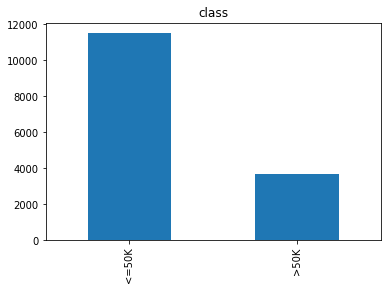

In [20]:
adult_set_for_training, adult_testing = data_utils.data_split(adult_dataset, 70)
adult_training, adult_validation = data_utils.split_training_data_for_pruning(adult_set_for_training)

print(adult_training['CLASS'].value_counts())
adult_training['CLASS'].value_counts().plot(kind='bar', title='class')

<AxesSubplot:title={'center':'class'}>

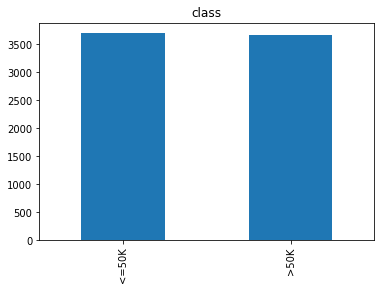

In [21]:
resampling_adult = adult_training.copy()
less_50k_part = resampling_adult[resampling_adult['CLASS'] == '<=50K']
more_50k_part = resampling_adult[resampling_adult['CLASS'] == '>50K'] 

less_50k_part_downsampled = resample(less_50k_part, 
                                 replace=False,    
                                 n_samples=3706)

# Combine minority class with downsampled majority class
balanced_adult_training = pd.concat([less_50k_part_downsampled, more_50k_part])
balanced_adult_training = balanced_adult_training.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='')
balanced_adult_training = balanced_adult_training.sample(frac=1).reset_index(drop=True)

adult_training = balanced_adult_training.copy()
adult_training['CLASS'].value_counts().plot(kind='bar', title='class')

## Model Training

In [22]:
adult_tree= dt_tree.build_tree_generic(dt_heur.mdl_simple,adult_training)
pprint(adult_tree)

tree_accuracy_adult_testing = tree_utils.tree_accuracy(adult_testing, adult_tree)
tree_accuracy_adult_training = tree_utils.tree_accuracy(adult_training, adult_tree)

{<occupation(-14.65)>: ?[348] Adm-clerical[705] Armed-Forces[5] Craft-repair[892] Exec-managerial[1236] Farming-fishing[177] Handlers-cleaners[245] Machine-op-inspct[415] Other-service[531] Priv-house-serv[16] Prof-specialty[1199] Protective-serv[155] Sales[844] Tech-support[232] Transport-moving[373] : {'?': {<education(-7.96)>: 10th[24] 11th[14] 12th[5] 5th-6th[4] 7th-8th[15] 9th[9] Assoc-acdm[11] Assoc-voc[15] Bachelors[46] Doctorate[6] HS-grad[92] Masters[14] Preschool[2] Prof-school[4] Some-college[87] : {'10th': '<=50K',
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                              'Separated': '<=50K',
                                                                                                                                                                                                                                                                                                                                                                                                                                                                              'Widowed': '<=50K'}},
                                

In [23]:
print("Tree accuracy for testing data {0}% and for training {1}%\n".format(tree_accuracy_adult_testing, tree_accuracy_adult_training ))
print("Tree number of levels:", tree_utils.number_of_levels(adult_tree))
print("Tree number of leafs:", tree_utils.number_of_leafs(adult_tree))

Tree accuracy for testing data 77.45931006244243% and for training 79.49274379492743%

Tree number of levels: 10
Tree number of leafs: 484


In [24]:
pruned_tree_adult = tree_pruning.reduced_error_pruning(adult_tree, adult_validation)
pprint(pruned_tree_adult)

{<occupation(-14.65)>: ?[348] Adm-clerical[705] Armed-Forces[5] Craft-repair[892] Exec-managerial[1236] Farming-fishing[177] Handlers-cleaners[245] Machine-op-inspct[415] Other-service[531] Priv-house-serv[16] Prof-specialty[1199] Protective-serv[155] Sales[844] Tech-support[232] Transport-moving[373] : {'?': '<=50K',
                                                                                                                                                                                                                                                                                                                  'Adm-clerical': '<=50K',
                                                                                                                                                                                                                                                                                                                  'Armed-Forces': '<=50K',
                  

In [25]:
tree_accuracy_adult_testing2 = tree_utils.tree_accuracy(adult_testing, pruned_tree_adult)
tree_accuracy_adult_training2 = tree_utils.tree_accuracy(adult_training, pruned_tree_adult)

print("Tree accuracy after pruning for testing data {0}% and for training {1}%\n".format(tree_accuracy_adult_testing2, tree_accuracy_adult_training2 ))
print("Tree number of levels:", tree_utils.number_of_levels(pruned_tree_adult))
print("Tree number of leafs:", tree_utils.number_of_leafs(pruned_tree_adult))

Tree accuracy after pruning for testing data 82.10666393694339% and for training 73.36226773362267%

Tree number of levels: 10
Tree number of leafs: 175
